# Retina Net

This notebook is implementing [RetinaNet](https://arxiv.org/pdf/1708.02002v2.pdf) and testing it on the COCO 2007 dataset. Comments are most of the time my own, and here and there Sylvain's.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

## Data

In [3]:
PATH = Path('../datasets/pascal/')
JPEGS_PATH = PATH/'VOCdevkit/VOC2007'
JPEGS_PATH.ls()

[PosixPath('../datasets/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('../datasets/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('../datasets/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('../datasets/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('../datasets/pascal/VOCdevkit/VOC2007/SegmentationObject')]

In [4]:
size = 256

In [5]:
images, lbl_bbox = get_annotations(PATH/'pascal_train2007.json')
images2, lbl_bbox2 = get_annotations(PATH/'pascal_val2007.json')
images += images2
lbl_bbox += lbl_bbox2
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]
data = (ObjectItemList.from_folder(JPEGS_PATH/'JPEGImages')
        #Where are the images?
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

In [6]:
data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f24071eb550>, device=device(type='cuda'), tfms=[], collate_fn=<function bb_pad_collate at 0x7f24074d7268>)

In [13]:
# train_ds = ObjectDetectDataset.from_json(JPEGS_PATH/'JPEGImages', ANNOT_PATH/'pascal_train2007.json')

In [ ]:
tfms = get_transforms()
train_tds = DatasetTfm(train_ds, tfms[0], tfm_y=True, size=224)

In [ ]:
x,y = train_tds[5]
x.show(y=y, classes=train_ds.classes, figsize=(6,4))

In [ ]:
size = 224

In [ ]:
tfms = ([flip_lr(p=0.5), crop_pad(size=size)], [crop_pad(size=size)])
train_tds = DatasetTfm(train_ds, tfms[0], tfm_y=True, size=size, padding_mode='zeros', do_crop=False)

In [ ]:
x,y = train_tds[0]
x.show(y=y, classes=train_ds.classes, figsize=(6,4))

In [ ]:
y.data

In [ ]:
x.size

In [6]:
#export
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0, pad_first:bool=True) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect samples and adds padding."
    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples): 
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        bboxes[i,-len(lbls):] = bbs
        labels[i,-len(lbls):] = lbls
    return torch.cat(imgs,0), (bboxes,labels)

In [ ]:
train_dl = DataLoader(train_tds, 64, shuffle=False, collate_fn=bb_pad_collate)

In [22]:
def show_sample(dl, rows, start=0):
    x,y = next(iter(dl))
    x = x[start:start+rows*rows].cpu()
    _,axs = plt.subplots(rows,rows,figsize=(9,9))
    for i, ax in enumerate(axs.flatten()):
        img = Image(x[i])
        idxs = y[1][start+i].nonzero()[:,0]
        if len(idxs) != 0:
            bbs,lbls = y[0][start+i][idxs],y[1][start+i][idxs]
            h,w = img.size
            bbs = ((bbs+1) * torch.tensor([h/2,w/2, h/2, w/2])).long()
            bbox = ImageBBox.create(bbs, *img.size, lbls)
            img.show(ax=ax, y=bbox, classes=dl.dataset.classes)
        else: img.show(ax=ax)
    plt.tight_layout()

In [68]:
show_sample(data.train_dl, 3, 18)

AttributeError: train_dl

In [ ]:
train_ds, valid_ds = ObjectDetectDataset.from_json(PATH/'train2017', ANNOT_PATH/'train_sample.json', valid_pct=0.2)
data = DataBunch.create(train_ds, valid_ds, path=PATH, ds_tfms=tfms, tfms=imagenet_norm, collate_fn=bb_pad_collate, 
                        num_workers=8, bs=16, size=128, tfm_y=True, padding_mode='zeros', do_crop=False)

In [5]:
def show_sample(data, rows, denorm=None):
    dl = data.train_dl
    x,y = next(iter(dl))
    x = x[:rows*rows].cpu()
    if denorm: x = denorm(x)
    _,axs = plt.subplots(rows,rows,figsize=(9,9))
    for i, ax in enumerate(axs.flatten()):
        img = Image(x[i])
        idxs = y[1][i].nonzero()[:,0]
        if len(idxs) != 0:
            bbs,lbls = y[0][i][idxs],y[1][i][idxs]
            h,w = img.size
            bbs = ((bbs.cpu()+1) * torch.tensor([h/2,w/2, h/2, w/2])).long()
            bbox = ImageBBox.create(*img.size, bbs, lbls, data.classes)
            img.show(ax=ax, y=bbox, classes=dl.dataset.classes)
        else: img.show(ax=ax)
    plt.tight_layout()

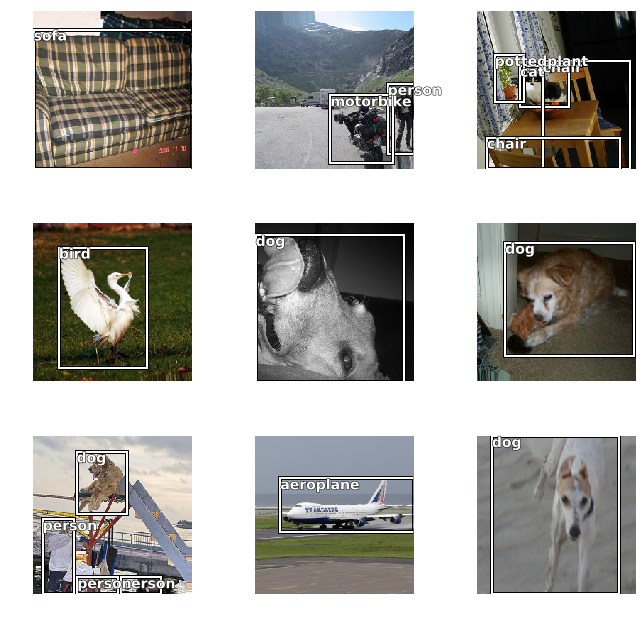

In [6]:
show_sample(data, 3)

## RetinaNet

Questions (also see TODO) : 
- How does the hook get passed through the model and stores the activation to add them later ? A : model_size pass hooks through the model and stores the activations in hook.stored
- Confirm P6 and P7 are somewhat outside the FPN, as they are directly computed from C5 and without lateral connections or a top-down connection

In [7]:
#export
def _get_sfs_idxs(sizes:Sizes) -> List[int]:
    """"
    Get the indexes of the layers where the size of the activation changes.
    Those indexes are those of the last layer of each stage as defined in the RetinaNet paper
    """
    feature_szs = [size[-1] for size in sizes]
    sfs_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    if feature_szs[0] != feature_szs[1]: sfs_idxs = [0] + sfs_idxs
    return sfs_idxs

In [9]:
encoder = create_body(models.resnet50, pretrained=True, cut=-2)

In [8]:
#export
class LateralUpsampleMerge(nn.Module):
    "Upsample a layer and adds the corresponding layer from the bottom-up path"
    def __init__(self, ch, ch_lat, hook):
        super().__init__()
        # stores the activation of ResNet50
        self.hook = hook
        # lateral connection
        self.conv_lat = conv2d(ch_lat, ch, ks=1, bias=True)
    
    def forward(self, x):
        # add bottom-up and top-down pathway to form the lateral connection. 
        # Interpolate is the upsampling method for the top-down path.
        return self.conv_lat(self.hook.stored) + F.interpolate(x, scale_factor=2)

From RetinaNet Paper :
> RetinaNet uses feature pyramid levels P<sub>3</sub> to P<sub>7</sub>, where P<sub>3</sub> to P<sub>5</sub> are
computed from the output of the corresponding ResNet residual stage (C<sub>3</sub>
through C<sub>5</sub>) using top-down and lateral connections just as in [20], P<sub>6</sub> is
obtained via a 3×3 stride-2 conv on C<sub>5</sub>, and P<sub>7</sub> is computed by applying ReLU followed by a 3×3 stride-2 conv on P<sub>6</sub>. This differs slightly
from [the FPN paper]: (1) we don’t use the high-resolution pyramid level P<sub>2</sub> for computational reasons, (2) P<sub>6</sub> is computed by strided convolution instead of
downsampling, and (3) we include P<sub>7</sub> to improve large object detection.
These minor modifications improve speed while maintaining accuracy

In [9]:
#export
class RetinaNet(nn.Module):
    "Implements RetinaNet from https://arxiv.org/abs/1708.02002"
    def __init__(self, encoder:nn.Module, n_classes, final_bias=0., chs=256, n_anchors=9, flatten=True):
        super().__init__()
        self.n_classes,self.flatten = n_classes,flatten
        imsize = (256,256)
        # sfs_szs stores the size of all the layers of the encoder and hooks has the activations in hook.stored
        sfs_szs = model_sizes(encoder, size=imsize)
        hooks = hook_outputs(encoder)
        # indexes of final layer of each stage
        sfs_idxs = _get_sfs_idxs(sfs_szs)
        self.encoder = encoder
        # compute P3 to P5
        self.c5top5 = conv2d(sfs_szs[-1][1], chs, ks=1, bias=True)
        # compute P6
        self.c5top6 = conv2d(sfs_szs[-1][1], chs, stride=2, bias=True)
        # compute P7
        self.p6top7 = nn.Sequential(nn.ReLU(), conv2d(chs, chs, stride=2, bias=True))
        # top-down and lateral connections
        self.merges = nn.ModuleList([LateralUpsampleMerge(chs, szs[1], hook) 
                                     for szs,hook in zip(sfs_szs[-2:-4:-1], hooks[-2:-4:-1])])
        # 3x3 conv2d used to eliminate aliasing caused by the upsampling
        self.smoothers = nn.ModuleList([conv2d(chs, chs, 3, bias=True) for _ in range(3)])
        self.classifier = self._head_subnet(n_classes, n_anchors, final_bias, chs=chs)
        self.box_regressor = self._head_subnet(4, n_anchors, 0., chs=chs)
        
    def _head_subnet(self, n_classes, n_anchors, final_bias=0., n_conv=4, chs=256):
        "return the head of the model (regression or classification)"
        layers = [nn.Sequential(conv_layer(chs, chs, bias=True), nn.ReLU()) for _ in range(n_conv)]
        # TODO : understand why the number of output channels is n_classes * n_anchors
        layers += [conv2d(chs, n_classes * n_anchors, bias=True)]
        # replace the bias of the last layer by final_bias
        layers[-1].bias.data.zero_().add_(final_bias)
        # set the weights of the last layer to 0
        layers[-1].weight.data.fill_(0)
        return nn.Sequential(*layers)
    
    def _apply_transpose(self, func, p_states, n_classes):
        # permute doc : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.permute
        # TODO : understand this
        if not self.flatten: 
            sizes = [[p.size(0), p.size(2), p.size(3)] for p in p_states]
            return [func(p).permute(0,2,3,1).view(*sz,-1,n_classes) for p,sz in zip(p_states,sizes)]
        else:
            return torch.cat([func(p).permute(0,2,3,1).contiguous().view(p.size(0),-1,n_classes) for p in p_states],1)
    
    def forward(self, x):
        c5 = self.encoder(x)
        # p[0] stores M5 (the top of the top-down pathway) and p[1] is the future P6 
        p_states = [self.c5top5(c5.clone()), self.c5top6(c5)]
        # p[2] is the future P7
        p_states.append(self.p6top7(p_states[-1]))
        # take m5 and take it through the top-down pathway using the LateralUpsampleMerge instances stored in self.merges
        # at the end of that line there's in p_states m5, m4, m3, m2 and two weird stuff -> TODO
        for merge in self.merges: p_states = [merge(p_states[0])] + p_states
        # apply anti-aliasing 3x3 conv2d
        for i, smooth in enumerate(self.smoothers[:3]):
            p_states[i] = smooth(p_states[i])
        # first is the classifier head, then the regressor head, then HxW of output of FPN
        return [self._apply_transpose(self.classifier, p_states, self.n_classes), 
                self._apply_transpose(self.box_regressor, p_states, 4),
                [[p.size(2), p.size(3)] for p in p_states]]
    
    
    

In [10]:
def model_sizes(m:nn.Module, size:tuple=(64,64))->Tuple[Sizes,Tensor,Hooks]:
    "Pass a dummy input through the model `m` to get the various sizes of activations."
    # changed the fastai function by adding `hook` to the return value
    with hook_outputs(m) as hooks:
        x = dummy_eval(m, size)
        return [o.stored.shape for o in hooks]

In [42]:
encoder = create_body(models.resnet50, pretrained=True, cut=-2)
model = RetinaNet(encoder, 6, -4) 
model.eval()
x = torch.randn(2,3,256,256)
output = model(x)

To be confirmed but the output is :
- `output[0]` is the classes for all the anchors
- `output[1]` is the boxes for all the anchors
- `output[2]` is the size of each feature maps being fed to the subnet heads

In [13]:
[y.size() for y in output[:2]], output[2]

([torch.Size([2, 12276, 6]), torch.Size([2, 12276, 4])],
 [[32, 32], [16, 16], [8, 8], [4, 4], [2, 2]])

## Anchors

We need to create the corresponding anchors in this order:

In [14]:
torch.arange(1,17).long().view(4,4)

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])

In [11]:
#export
def create_grid(size):
    "Create a grid of a given `size`."
    H, W = size if is_tuple(size) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

Convention (-1.,-1.) to (1.,1.), first is y, second is x (like for the bboxes). -1 is left/top, 1 is right/bottom.

In [12]:
#export
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

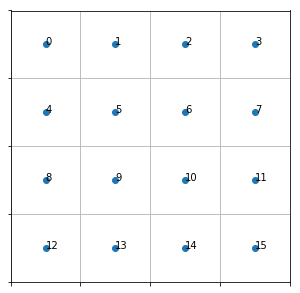

In [17]:
size = (4,4)
show_anchors(create_grid(size), size)

In [13]:
#export
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        #4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [14]:
ratios = [1/2,1,2]
#scales = [1,2**(-1/3), 2**(-2/3)]
scales = [1,2**(1/3), 2**(2/3)]
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse()
anchors = create_anchors(sizes, ratios, scales)

In [20]:
anchors.size()
#[anc.size() for anc in anchors]

torch.Size([3069, 4])

In [15]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [16]:
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i%num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i%num_color])

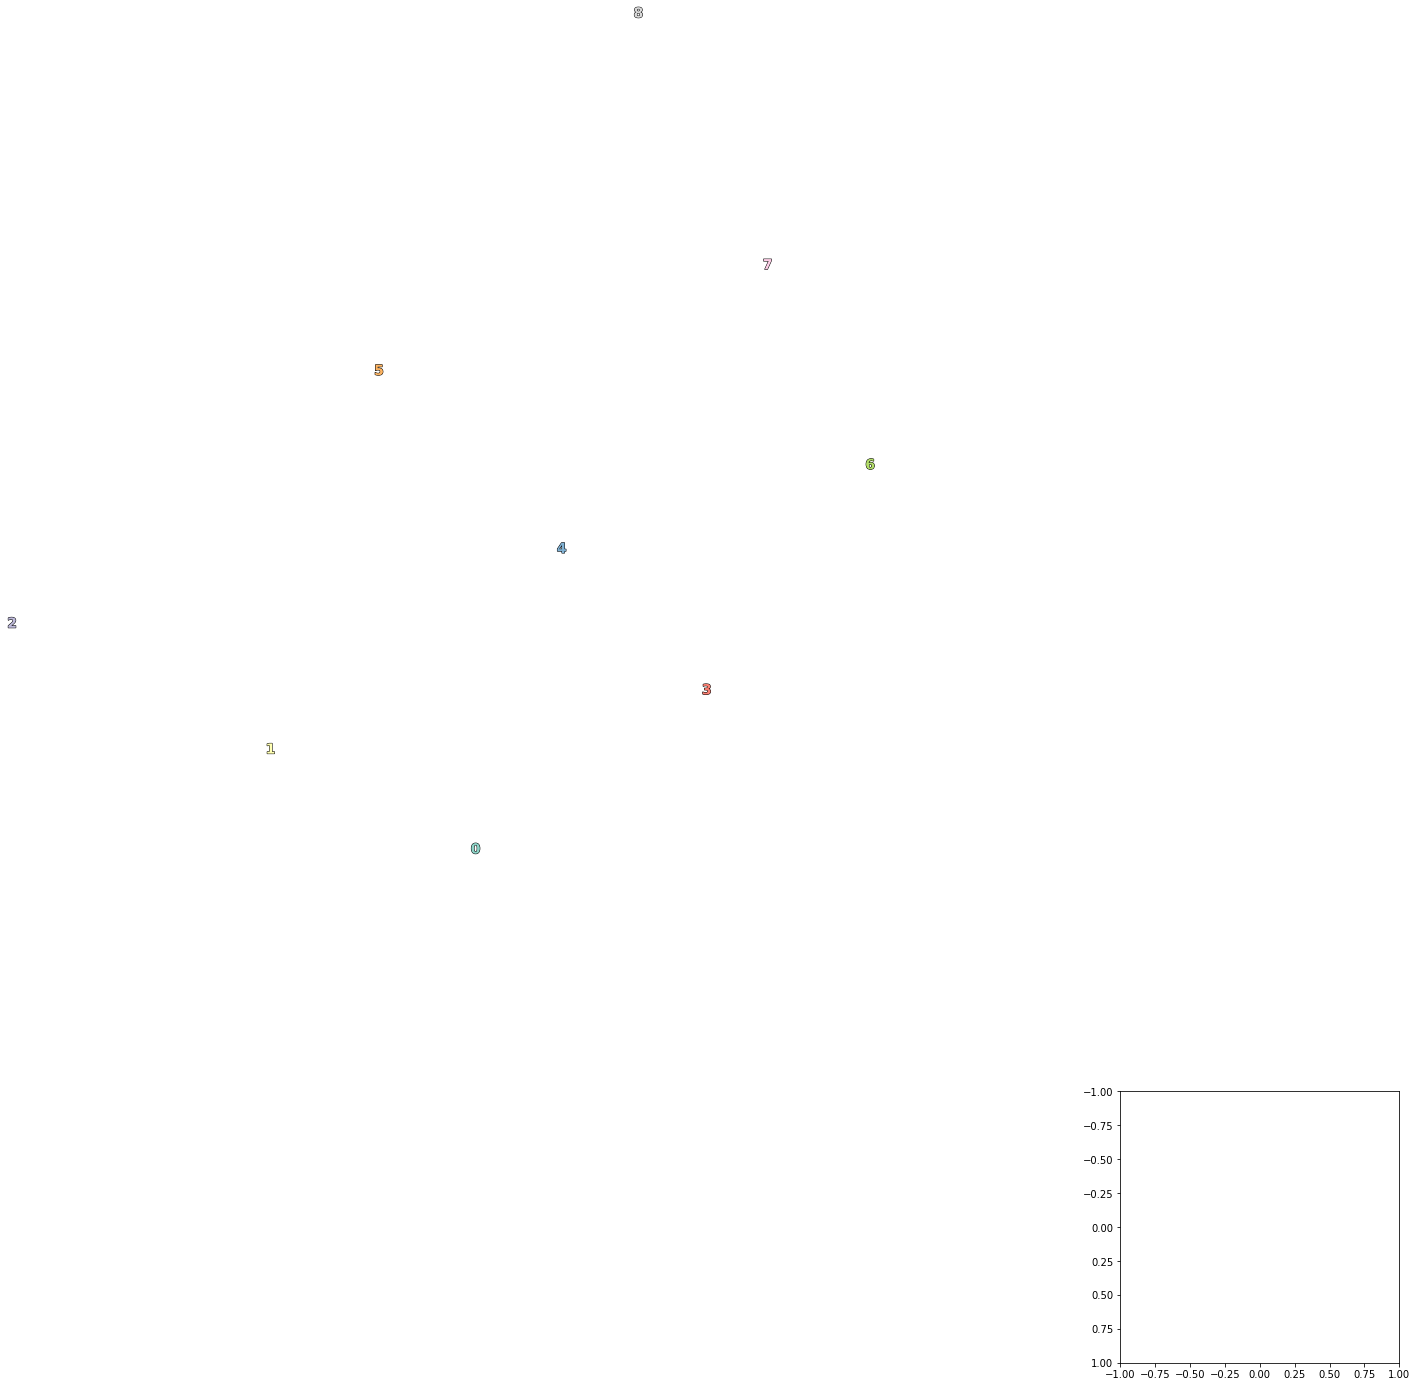

In [23]:
show_boxes(anchors[-9:])

In [17]:
#export
def activ_to_bbox(acts, anchors, flatten=True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [25]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)

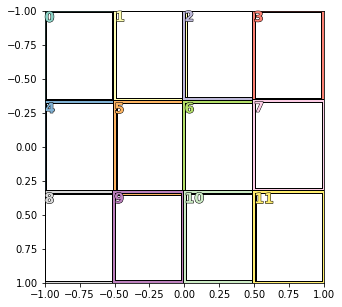

In [26]:
show_boxes(bboxes)

In [18]:
#export
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [19]:
#export
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

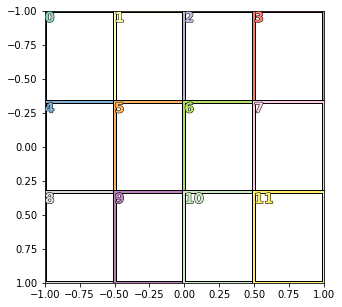

In [29]:
show_boxes(anchors)

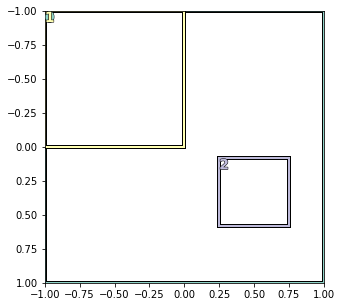

In [30]:
targets = torch.tensor([[0.,0.,2.,2.], [-0.5,-0.5,1.,1.], [1/3,0.5,0.5,0.5]])
show_boxes(targets)

In [31]:
intersection(anchors, targets)

tensor([[0.3333, 0.3333, 0.0000],
        [0.3333, 0.3333, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.1667, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0625],
        [0.3333, 0.0000, 0.0625]])

In [20]:
#export
def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

In [33]:
IoU_values(anchors, targets)

tensor([[0.0833, 0.3333, 0.0000],
        [0.0833, 0.3333, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.1429, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.0000],
        [0.0833, 0.0000, 0.1200],
        [0.0833, 0.0000, 0.1200]])

Manually checked that those are right.

In [21]:
#export
def match_anchors(anchors, targets, match_thr=0.5, bkg_thr=0.4):
    "Match `anchors` to targets. -1 is match to background, -2 is ignore."
    ious = IoU_values(anchors, targets)
    matches = anchors.new(anchors.size(0)).zero_().long() - 2
    vals,idxs = torch.max(ious,1)
    matches[vals < bkg_thr] = -1
    matches[vals > match_thr] = idxs[vals > match_thr]
    #Overwrite matches with each target getting the anchor that has the max IoU.
    #vals,idxs = torch.max(ious,0)
    #If idxs contains repetition, this doesn't bug and only the last is considered.
    #matches[idxs] = targets.new_tensor(list(range(targets.size(0)))).long()
    return matches

Last example

In [35]:
match_anchors(anchors, targets)

tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

With anchors very close to the targets.

In [36]:
size=(3,4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
activations = 0.1 * torch.randn(size[0]*size[1], 4)
bboxes = activ_to_bbox(activations, anchors)
match_anchors(anchors,bboxes)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

With anchors in the grey area.

In [37]:
anchors = create_grid((2,2))
anchors = torch.cat([anchors, torch.tensor([1.,1.]).expand_as(anchors)], 1)
targets = anchors.clone()
anchors = torch.cat([anchors, torch.tensor([[-0.5,0.,1.,1.8]])], 0)
match_anchors(anchors,targets)

tensor([ 0,  1,  2,  3, -2])

In [22]:
#export
def tlbr2cthw(boxes):
    "Convert top/left bottom/right format `boxes` to center/size corners."
    center = (boxes[:,:2] + boxes[:,2:])/2
    sizes = boxes[:,2:] - boxes[:,:2]
    return torch.cat([center, sizes], 1)

In [23]:
#export
def bbox_to_activ(bboxes, anchors, flatten=True):
    "Return the target of the model on `anchors` for the `bboxes`."
    if flatten:
        t_centers = (bboxes[...,:2] - anchors[...,:2]) / anchors[...,2:] 
        t_sizes = torch.log(bboxes[...,2:] / anchors[...,2:] + 1e-8) 
        return torch.cat([t_centers, t_sizes], -1).div_(bboxes.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [24]:
#export
def encode_class(idxs, n_classes):
    """
    Return matrix of len(idxs) x n_classes of 0s where if element i of idxs != 0 : [i index][i-1] = 1
    Basically each class has a column and there's a one in that column at the position (and if) of the number in
    idxs that correspond to that class
    """
    target = idxs.new_zeros(len(idxs), n_classes).float()
    mask = idxs != 0
    i1s = LongTensor(list(range(len(idxs))))
    target[i1s[mask],idxs[mask]-1] = 1
    return target

In [41]:
encode_class(LongTensor([1,2,0,1,3]),3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.]])

 ## Focal Loss

Formula for Focal Loss :
$$ FL(p_t) = -\alpha_t (1 - p_t)^\gamma log(p_t)$$
where 
$$ p_t = \begin{cases}
    p & \text{if } y = 1\\
    1-p              & \text{otherwise}
\end{cases} $$
and
$$ \alpha_t = \begin{cases}
    \alpha & \text{if } y = 1\\
    1-\alpha              & \text{otherwise}
\end{cases} $$

In [25]:
#export
class RetinaNetFocalLoss(nn.Module):
    
    def __init__(self, gamma:float=2., alpha:float=0.25,  pad_idx:int=0, scales:Collection[float]=None, 
                 ratios:Collection[float]=None, reg_loss:LossFunction=F.smooth_l1_loss):
        super().__init__()
        self.gamma,self.alpha,self.pad_idx,self.reg_loss = gamma,alpha,pad_idx,reg_loss
        self.scales = ifnone(scales, [1,2**(-1/3), 2**(-2/3)])
        self.ratios = ifnone(ratios, [1/2,1,2])
        
    def _change_anchors(self, sizes:Sizes) -> bool:
        if not hasattr(self, 'sizes'): return True
        for sz1, sz2 in zip(self.sizes, sizes):
            if sz1[0] != sz2[0] or sz1[1] != sz2[1]: return True
        return False
    
    def _create_anchors(self, sizes:Sizes, device:torch.device):
        self.sizes = sizes
        self.anchors = create_anchors(sizes, self.ratios, self.scales).to(device)
    
    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt-self.pad_idx))
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:]-1+self.pad_idx
    
    def _focal_loss(self, clas_pred, clas_tgt):
        "compute focal loss"
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        # compute p_t for each prediction
        ps = torch.sigmoid(clas_pred)
        weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
        # compute the alpha for each prediction
        alphas = (1-encoded_tgt) * self.alpha + encoded_tgt * (1-self.alpha)
        weights.pow_(self.gamma).mul_(alphas)       
        weights_no_grad = weights.detach()
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights_no_grad, reduction='sum')
        return clas_loss
        
    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches>=0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else: bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches>=0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss + self._focal_loss(clas_pred, clas_tgt)/torch.clamp(bbox_mask.sum(), min=1.)
    
    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if self._change_anchors(sizes): self._create_anchors(sizes, clas_preds.device)
        n_classes = clas_preds.size(2)
        return sum([self._one_loss(cp, bp, ct, bt)
                    for (cp, bp, ct, bt) in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts)])/clas_tgts.size(0)

Alternative to the L1 smooth loss used in online implementations

In [26]:
#export
class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()

Sketch to test the loss

In [44]:
LongTensor([[[0,0,64,128,0], [32,64,128,128,1]], [[128,96,256,192,2], [96,192,128,256,3]]]).float().cuda()

tensor([[[  0.,   0.,  64., 128.,   0.],
         [ 32.,  64., 128., 128.,   1.]],

        [[128.,  96., 256., 192.,   2.],
         [ 96., 192., 128., 256.,   3.]]], device='cuda:0')

In [45]:
tgt_clas = LongTensor([[1,2], [3,4]])
tgt_bbox = FloatTensor([[[0,0,128,64], [64,32,128,128]], [[96,128,192,256], [192,96,256,128]]])
tgt_bbox = tgt_bbox / 128 - 1.
y = [tgt_bbox.cuda(), tgt_clas.cuda()]

In [48]:
# clas = torch.load(PATH/'models'/'tst_clas.pth')
# regr = torch.load(PATH/'models'/'tst_regr.pth')
sizes = [[32, 32], [16, 16], [8, 8], [4, 4], [2, 2]]
# output = [logit(clas), regr, sizes]

In [50]:
# crit(output, *y)

Checking the output

In [27]:
#export
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

In [52]:
idx = 0
clas_pred,bbox_pred,sizes = output[0][idx].cpu(), output[1][idx].cpu(), output[2]
bbox_tgt, clas_tgt = y[0][idx].cpu(),y[1][idx].cpu()
bbox_tgt, clas_tgt = unpad(bbox_tgt, clas_tgt)

In [53]:
bbox_tgt

tensor([[-0.5000, -0.7500,  1.0000,  0.5000],
        [-0.2500, -0.3750,  0.5000,  0.7500]])

In [54]:
anchors = create_anchors(sizes, ratios, scales)
ious = IoU_values(anchors, bbox_tgt)
matches = match_anchors(anchors, bbox_tgt)

In [55]:
ious[-9:]

tensor([[0.0285, 0.0234],
        [0.0197, 0.0148],
        [0.0124, 0.0093],
        [0.0312, 0.0234],
        [0.0197, 0.0148],
        [0.0124, 0.0093],
        [0.0258, 0.0234],
        [0.0197, 0.0148],
        [0.0124, 0.0093]])

In [56]:
(matches==-2).sum(), (matches==-1).sum(), (matches>=0).sum()

(tensor(107), tensor(12105), tensor(64))

In [57]:
bbox_mask = matches>=0
bbox_pred = bbox_pred[bbox_mask]
bbox_tgt = bbox_tgt[matches[bbox_mask]]
bb_loss = F.smooth_l1_loss(bbox_pred, bbox_to_activ(bbox_tgt, anchors[bbox_mask]))

In [58]:
F.smooth_l1_loss(bbox_pred, bbox_to_activ(bbox_tgt, anchors[bbox_mask]))

tensor(0.6991, grad_fn=<SmoothL1LossBackward>)

In [59]:
tst_loss = SigmaL1SmoothLoss()
tst_loss(bbox_pred, bbox_to_activ(bbox_tgt, anchors[bbox_mask]))

tensor(1.1054, grad_fn=<MeanBackward1>)

In [61]:
# crit.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, anchors[bbox_mask]))

In [62]:
matches.add_(1)
clas_tgt += 1
clas_mask = matches>=0
clas_pred = clas_pred[clas_mask]
clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
clas_tgt = clas_tgt[matches[clas_mask]]

Focal loss

In [69]:
alpha, gamma, n_classes = 0.25, 2., 6
encoded_tgt = encode_class(clas_tgt, n_classes)
ps = torch.sigmoid(clas_pred)
weights = encoded_tgt * (1-ps) + (1-encoded_tgt) * ps
alphas = encoded_tgt * alpha + (1-encoded_tgt) * (1-alpha)
weights.pow_(gamma).mul_(alphas)
clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum') / bbox_mask.sum()
clas_loss

RuntimeError: the derivative for 'weight' is not implemented

Let's look at the objects missclassified.

In [64]:
clas_pred[clas_tgt.nonzero().squeeze()]

tensor([[-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],
        [-4., -4., -4., -4., -4., -4.],


In [65]:
F.binary_cross_entropy_with_logits(clas_pred[clas_tgt.nonzero().squeeze()], encoded_tgt[clas_tgt.nonzero().squeeze()], weights[clas_tgt.nonzero().squeeze()], reduction='sum') / bbox_mask.sum()

RuntimeError: the derivative for 'weight' is not implemented

They account for half the loss!

## Training

In [32]:
model=None
encoder = None
gc.collect()

210

In [33]:
n_classes = 6
encoder = create_body(models.resnet50, pretrained=True, cut=-2)
model = RetinaNet(encoder, n_classes,final_bias=-4) 
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)
learn = Learner(data, model, loss_func=crit)

In [34]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze()

In [41]:
learn.lr_find()

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1544176307774/work/torch/csrc/generic/serialization.cpp:15

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-4)

In [ ]:
learn.save('sample')

## Inference

In [ ]:
learn.load('sample')

In [ ]:
img,target = next(iter(data.valid_dl))
with torch.no_grad():
    output = model(img)

In [ ]:
torch.save(img, PATH/'models'/'tst_input.pth')

In [ ]:
def _draw_outline(o:Patch, lw:int):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax:plt.Axes, b:Collection[int], color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [ ]:
def show_preds(img, output, idx, detect_thresh=0.3, classes=None):
    clas_pred,bbox_pred,sizes = output[0][idx].cpu(), output[1][idx].cpu(), output[2]
    anchors = create_anchors(sizes, ratios, scales)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    _, ax = plt.subplots(1,1)
    for bbox, c in zip(bbox_pred, clas_pred.argmax(1)):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=txt)

In [ ]:
idx = 0
img = data.valid_ds[idx][0]
classes = data.train_ds.classes
show_preds(img, output, idx, detect_thresh=0.2, classes=classes)

In [ ]:
#export
def nms(boxes, scores, thresh=0.5):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        #pdb.set_trace()
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals <= thresh
        if len(mask_keep.nonzero()) == 0: break
        idx_first = mask_keep.nonzero().min().item()
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

In [ ]:
#export
def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [ ]:
def show_preds(img, output, idx, detect_thresh=0.25, classes=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    to_keep = nms(bbox_pred, scores)
    bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
    t_sz = torch.Tensor([*img.size])[None].float()
    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
    bbox_pred = bbox_pred.long()
    _, ax = plt.subplots(1,1)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        img.show(ax=ax)
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

In [ ]:
idx = 0
img = data.valid_ds[idx][0]
show_preds(img, output, idx, detect_thresh=0.2, classes=data.classes)

In [ ]:
#export
def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

In [ ]:
get_predictions(output, 0)

## mAP

In [ ]:
#export
def compute_ap(precision, recall):
    "Compute the average precision for `precision` and `recall` curve."
    recall = np.concatenate(([0.], list(recall), [1.]))
    precision = np.concatenate(([0.], list(precision), [0.]))
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])
    idx = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[idx + 1] - recall[idx]) * precision[idx + 1])
    return ap

In [ ]:
#export
def compute_class_AP(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.05, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    with torch.no_grad():
        for input,target in progress_bar(dl):
            output = model(input)
            for i in range(target[0].size(0)):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                tgt_bbox, tgt_clas = unpad(target[0][i], target[1][i])
                ious = IoU_values(bbox_pred, tgt_bbox)
                max_iou, matches = ious.max(1)
                detected = []
                for i in range_of(preds):
                    if max_iou[i] >= iou_thresh and matches[i] not in detected and tgt_clas[matches[i]] == preds[i]:
                        detected.append(matches[i])
                        tps.append(1)
                    else: tps.append(0)
                clas.append(preds.cpu())
                p_scores.append(scores.cpu())
                n_gts += (tgt_clas.cpu()[:,None] == classes[None,:]).sum(0)
    tps, p_scores, clas = torch.tensor(tps), torch.cat(p_scores,0), torch.cat(clas,0)
    fps = 1-tps
    idx = p_scores.argsort(descending=True)
    tps, fps, clas = tps[idx], fps[idx], clas[idx]
    aps = []
    #return tps, clas
    for cls in range(n_classes):
        tps_cls, fps_cls = tps[clas==cls].float().cumsum(0), fps[clas==cls].float().cumsum(0)
        if tps_cls[-1] != 0:
            precision = tps_cls / (tps_cls + fps_cls + 1e-8)
            recall = tps_cls / (n_gts[cls] + 1e-8)
            aps.append(compute_ap(precision, recall))
        else: aps.append(0.)
    return aps

In [ ]:
L = compute_class_AP(learn.model, tst_dl, 6)

In [ ]:
L[0]